In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [22]:
#Read, Clean, and Wrangle Data
cleveland_clean <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                            col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
                    mutate(if_hd = as.factor(num))|>
                    select(if_hd, age, thalach, chol, oldpeak, slope)

cleveland_clean$if_hd<- ifelse(cleveland_clean$if_hd == 0, "No", "Yes")
cleveland_clean$if_hd<-as.factor(cleveland_clean$if_hd)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
#Split into Training and Testing Sets
set.seed(6969)

data_split <- initial_split(cleveland_clean, prop = 0.80, strata = if_hd)
cleveland_train <- training(data_split)  
cleveland_test <- testing(data_split)

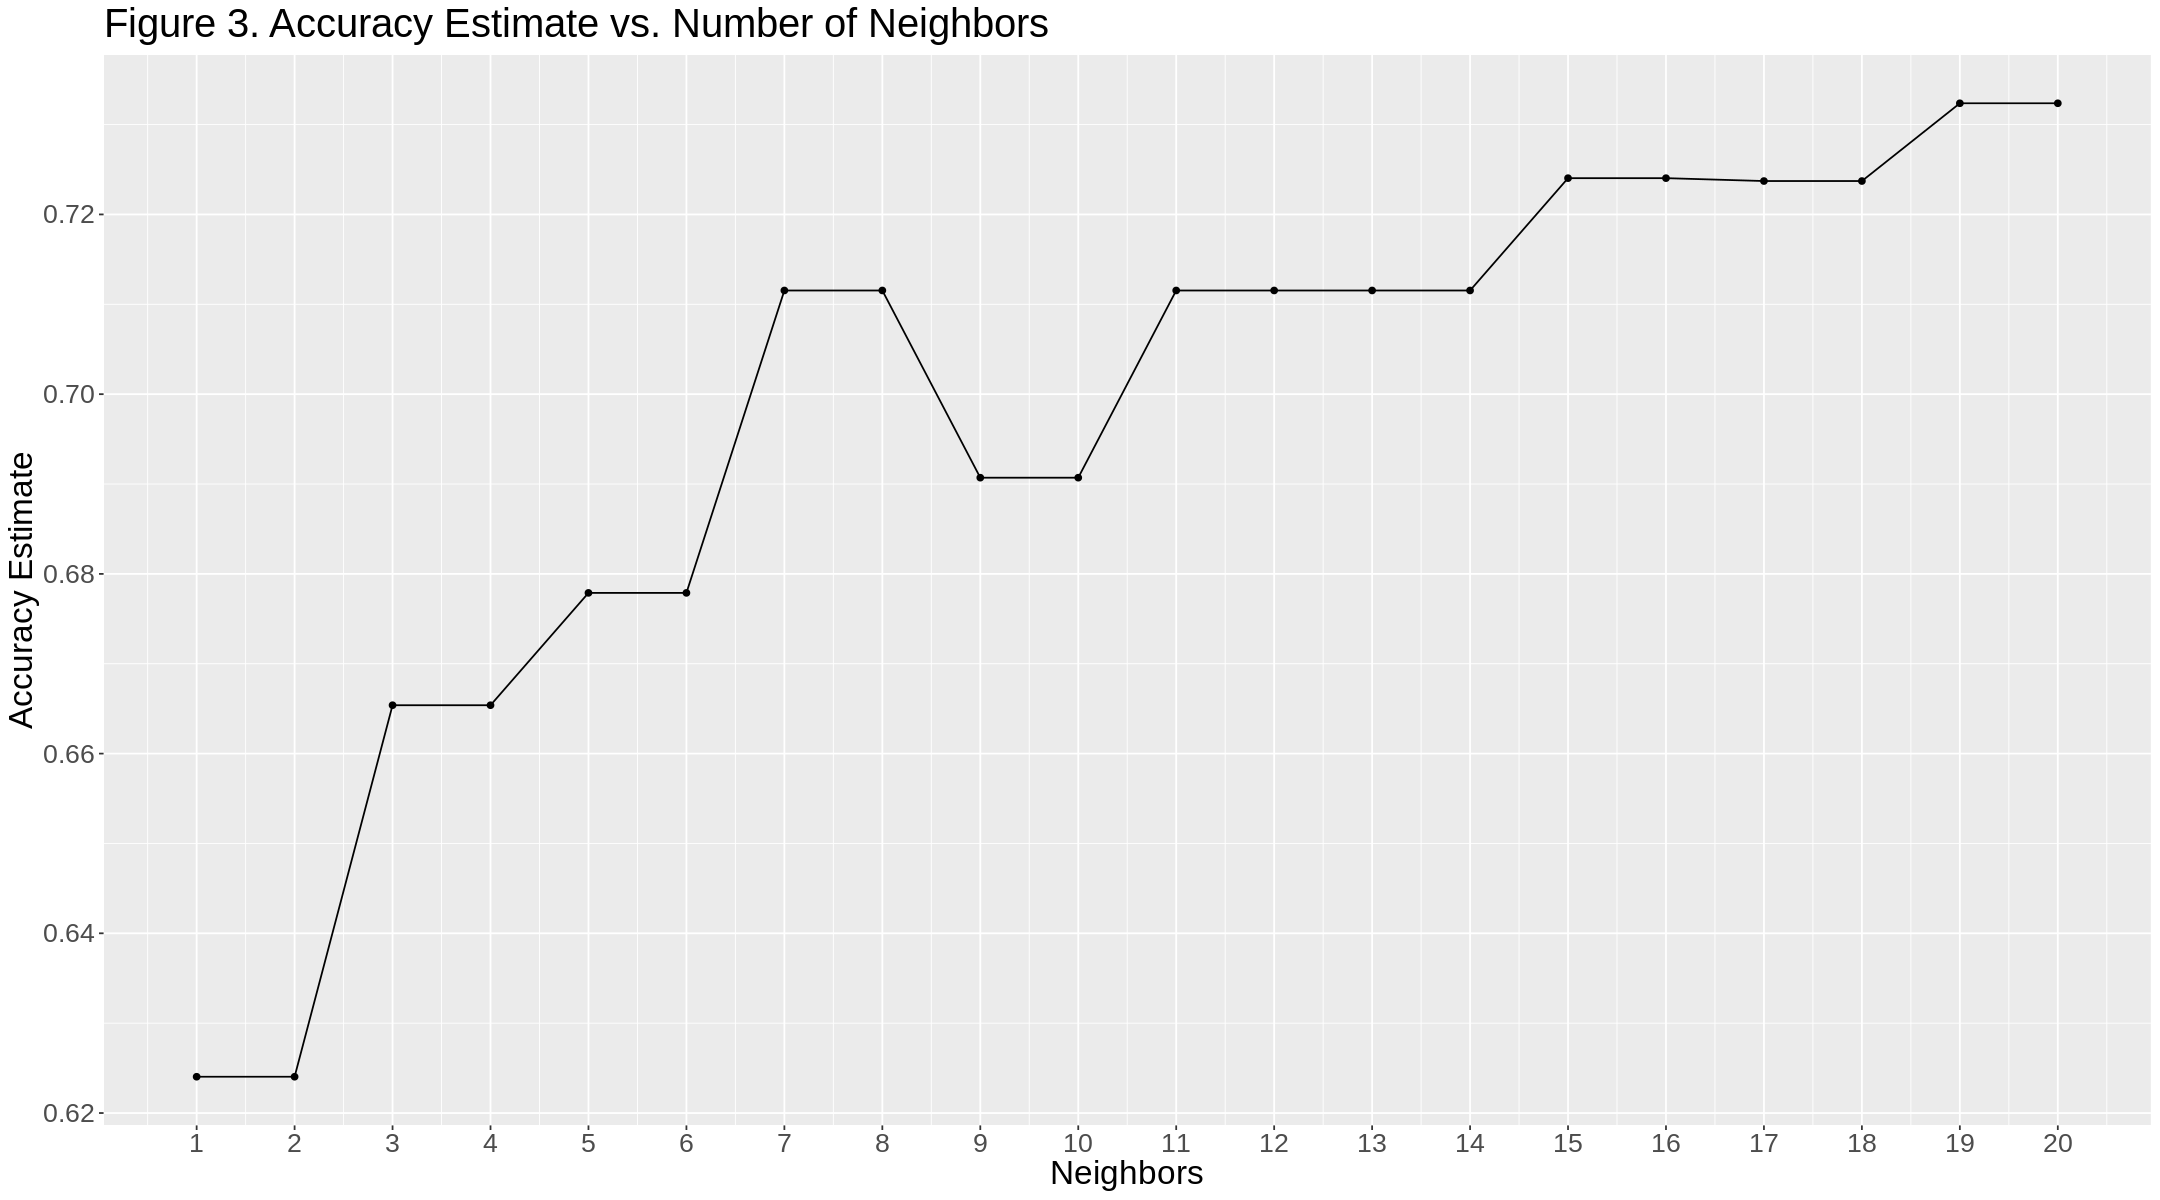

In [24]:
#Picking a value for K
set.seed(6969)
options(repr.plot.width = 18, repr.plot.height = 10)

cleveland_recipe <- recipe(if_hd ~ ., data = cleveland_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

vfold <- vfold_cv(cleveland_train, v = 10, strata = if_hd)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

cleveland_results <- workflow() |>
        add_recipe(cleveland_recipe) |>
        add_model(knn_tune) |>
        tune_grid(resamples = vfold, grid = k_vals) |>
        collect_metrics()

accuracies <- cleveland_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 100, by = 1))+ 
       ggtitle('Figure 3. Accuracy Estimate vs. Number of Neighbors') +
       theme(text = element_text(size=20))

cross_val_plot

In [25]:
#Seeing how well the model predicts the training set
knn_15 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
        set_engine("kknn") |>
        set_mode("classification")

knn_15_wf <- workflow() |>
        add_recipe(cleveland_recipe) |>
        add_model(knn_15) |>
        fit(data= cleveland_train)

cleveland_predict <- predict(knn_15_wf, cleveland_test) |>
    bind_cols(cleveland_test)

metrics <- cleveland_predict |>
    metrics(truth = if_hd, estimate = .pred_class)|>
    filter(.metric == 'accuracy')

metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7213115


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

<<<<<<< local


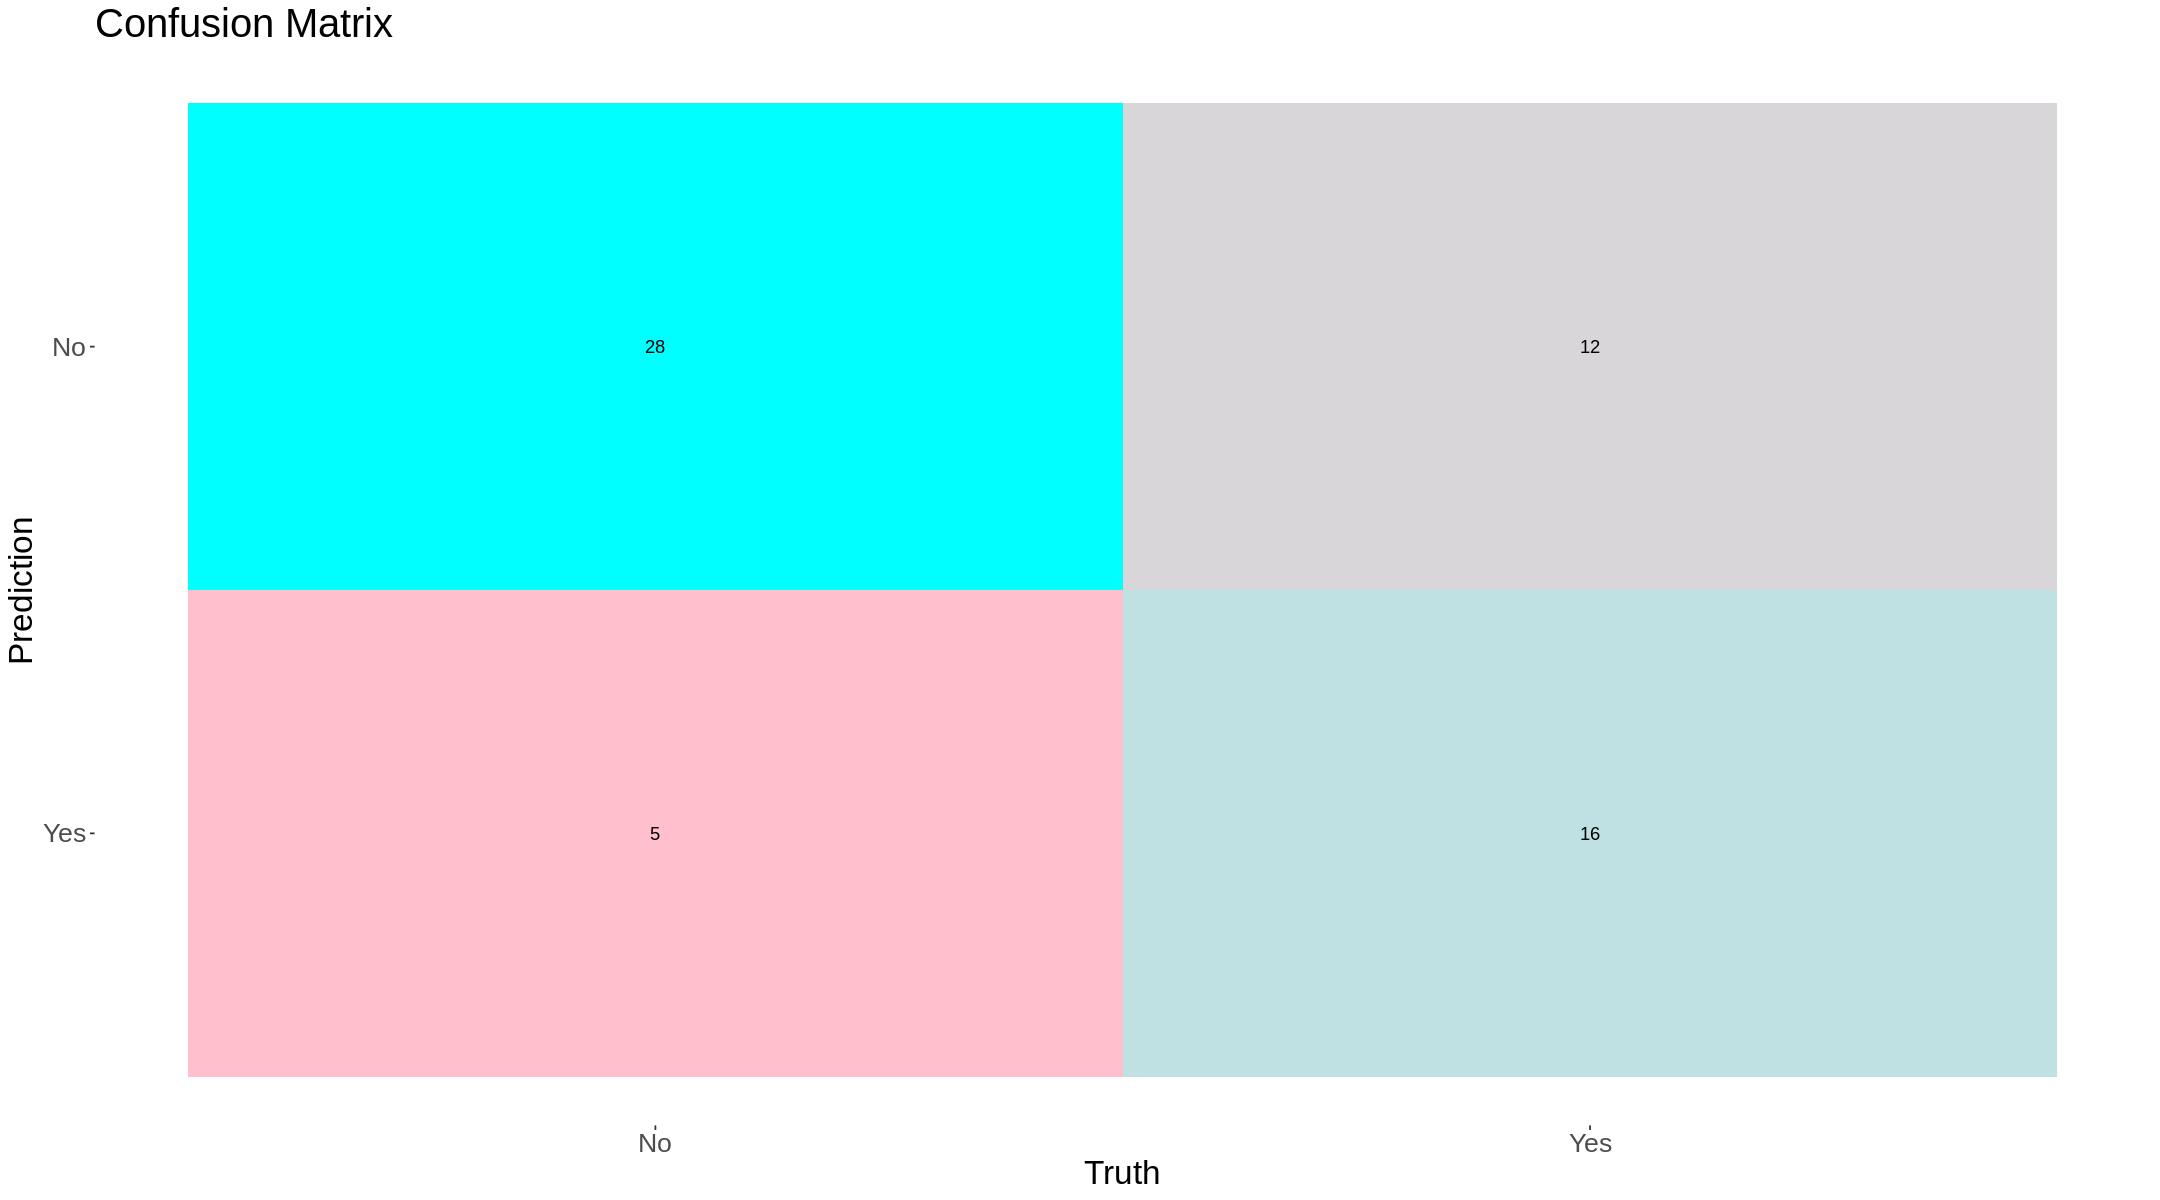

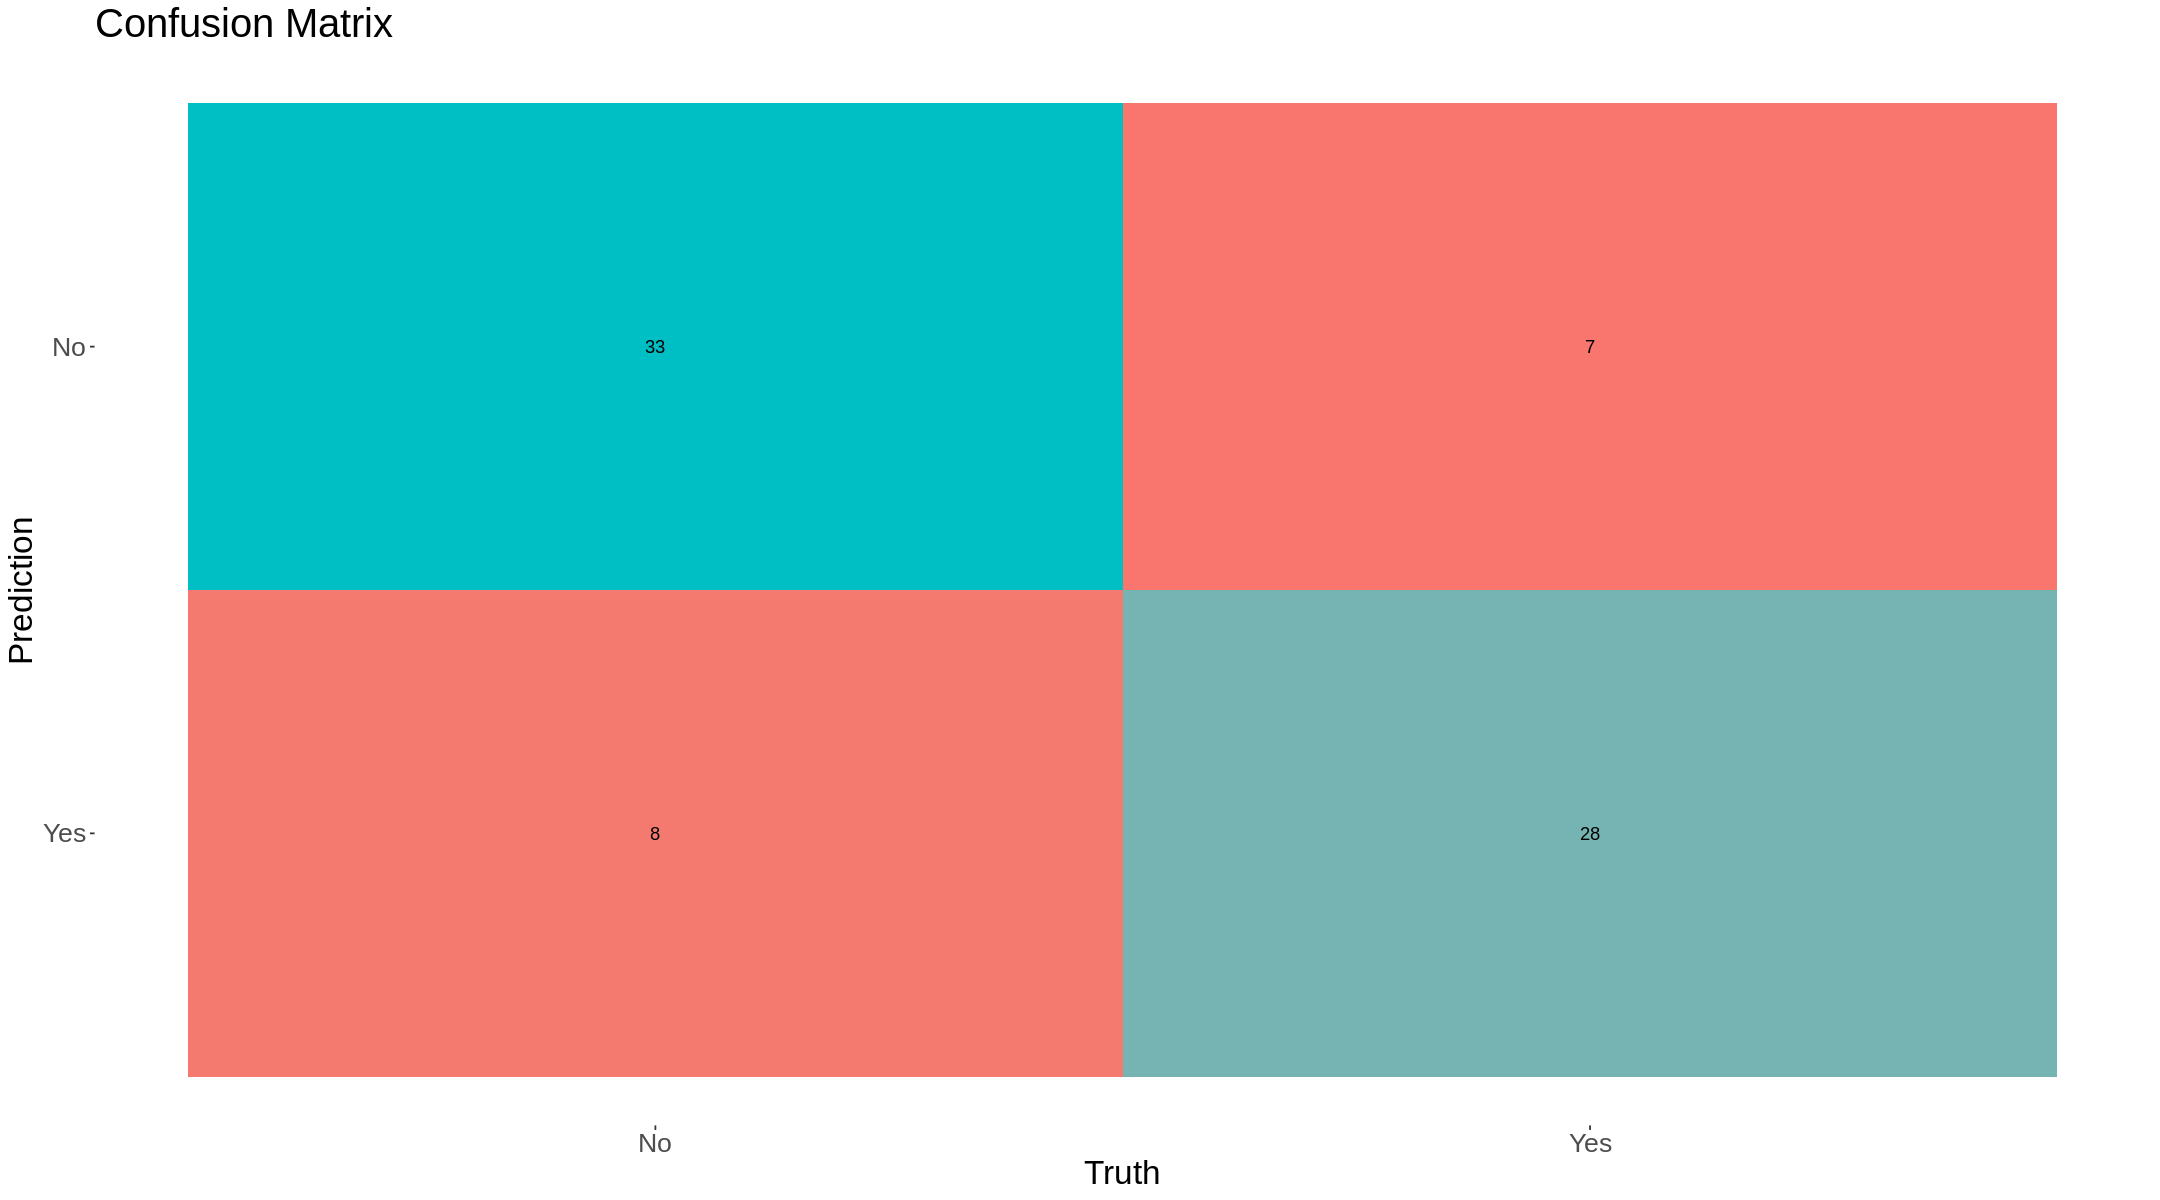

>>>>>>> remote


In [ ]:
confusion_matrix <- cleveland_predict |> 
                conf_mat(truth = if_hd, estimate = .pred_class) 

confusion_matrix_plot <- autoplot(confusion_matrix, type = "heatmap") + 
                labs(title = "Confusion Matrix") + 
                scale_fill_gradient(low = "#F8766D", high = "#00BFC4") +
                theme(text=element_text(size=20))
confusion_matrix_plot